In [1]:
import tensorflow as tf
from dataset import ISIC_Dataset
from config import *
from utility import dice_coefficient, IoU

In [2]:
# Image and mask file paths
data_path = "../../../ISIC_Data/ISIC-2017_Training_Data/*.jpg"
mask_path = "../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/*.png"

In [3]:
# Load data

lesion_data = ISIC_Dataset(data_path, mask_path, IMAGE_HEIGHT, IMAGE_WIDTH)

(train_x, train_y), (val_x, val_y), (test_x, test_y) = lesion_data.get_data_splits(0.8, 0.1, 0.1)

In [19]:
from modules import ImprovedUNet

model = ImprovedUNet(IMAGE_HEIGHT, IMAGE_WIDTH, 3, filters=16, kernel_size=(3, 3))
model.build_model(True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [20]:
model = model.model
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = "binary_crossentropy", metrics = [dice_coefficient, IoU])

In [21]:
# Train model
history = model.fit(train_x, train_y, epochs = 90, validation_data = (val_x, val_y), batch_size = 64)

Epoch 1/90
25/25 [==============================] - 13s 149ms/step - loss: 0.4302 - dice_similarity: 0.7745 - IoU: 0.6428 - val_loss: 0.2174 - val_dice_similarity: 0.9050 - val_IoU: 0.8269
Epoch 2/90
25/25 [==============================] - 3s 126ms/step - loss: 0.2523 - dice_similarity: 0.8686 - IoU: 0.7681 - val_loss: 0.2180 - val_dice_similarity: 0.8750 - val_IoU: 0.7778
Epoch 3/90
25/25 [==============================] - 3s 125ms/step - loss: 0.2178 - dice_similarity: 0.8992 - IoU: 0.8174 - val_loss: 0.1496 - val_dice_similarity: 0.9457 - val_IoU: 0.8974
Epoch 4/90
25/25 [==============================] - 3s 125ms/step - loss: 0.1655 - dice_similarity: 0.9304 - IoU: 0.8700 - val_loss: 0.1452 - val_dice_similarity: 0.9516 - val_IoU: 0.9082
Epoch 5/90
25/25 [==============================] - 3s 125ms/step - loss: 0.1589 - dice_similarity: 0.9345 - IoU: 0.8772 - val_loss: 0.1371 - val_dice_similarity: 0.9563 - val_IoU: 0.9168
Epoch 6/90
25/25 [==============================] - 3s 124m

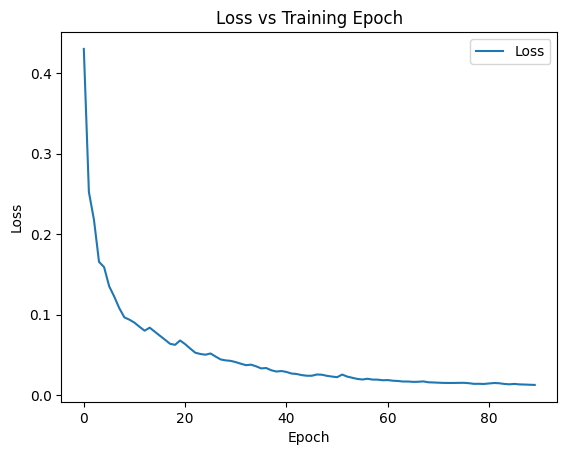

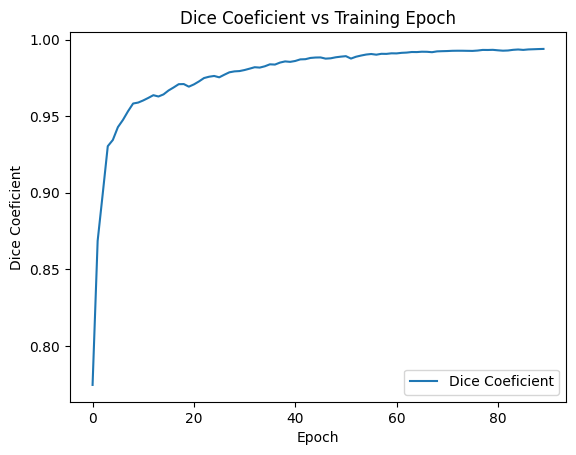

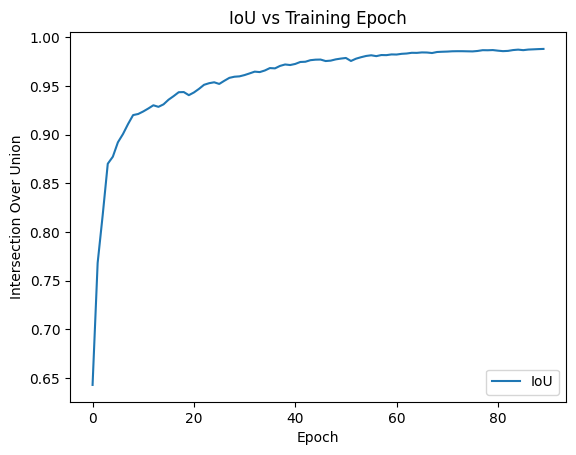

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training results
plt.figure(0)
plt.plot(history.history['loss'], label='Loss')
plt.title("Loss vs Training Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
# plt.savefig("./figures/lossVsEpoch.png")

plt.figure(1)
plt.plot(history.history['dice_coefficient'], label='Dice Coefficient')
plt.title("Dice Coefficient vs Training Epoch")
plt.xlabel('Epoch')
plt.ylabel('Dice Coeficient')
plt.legend(loc='lower right')
# plt.savefig("./figures/diceVsEpoch.png")

# IoU vs Epoch
plt.figure(2)
plt.plot(history.history['IoU'], label='IoU')
plt.title("IoU vs Training Epoch")
plt.xlabel('Epoch')
plt.ylabel('Intersection Over Union')
plt.legend(loc='lower right')
# plt.savefig("./figures/iouVsEpoch.png")

In [25]:
def make_prediction(model, test_x, test_y, slice=(0, 1)):
    """
    Make predictions on test data using trained model.
    
    Specify slice of test data to predict.
    """
    # Get predictions on test data from trained model
    predictions = model.predict(test_x)

    first_test = slice[0]
    last_test = slice[1]
    figure_counter = 0

    for i in range(first_test, last_test):
        plt.figure(figure_counter)
        figure_counter += 1

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        # Original Image Plot
        ax1.set_title("Original Image")
        ax1.axis("off")
        ax1.imshow(test_x[i])
        # Ground Truth Mask Plot
        ax2.set_title("Ground Truth Mask")
        ax2.axis("off")
        ax2.imshow(tf.argmax(test_y[i], axis=2), cmap='gray')
        # Get metrics
        pred_dice = np.around(dice_coefficient(
            test_y[i], predictions[i]).numpy(), 3)
        pred_iou = np.around(IoU(test_y[i], predictions[i]).numpy(), 3)
        
        ax3.set_title(f"Prediction")
        ax3.axis("off")
        ax3.text(0, 150, f"DSC={str(pred_dice)}, IoU={str(pred_iou)}")
        ax3.imshow(tf.argmax(predictions[i], axis=2), cmap='gray')

        plt.savefig(f"./figures/testComparison{i}.png", bbox_inches='tight')

    return

7/7 [==============================] - 1s 18ms/step


<Figure size 640x480 with 0 Axes>

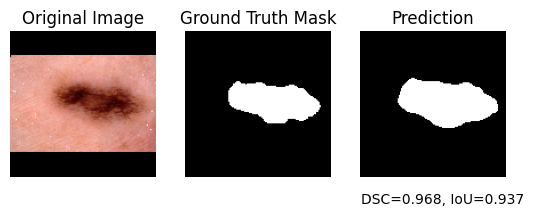

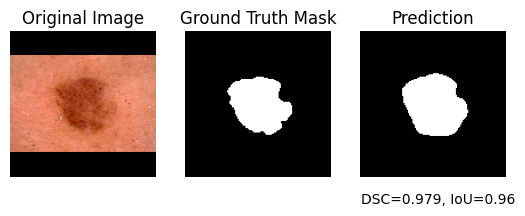

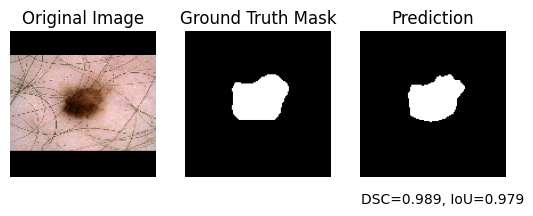

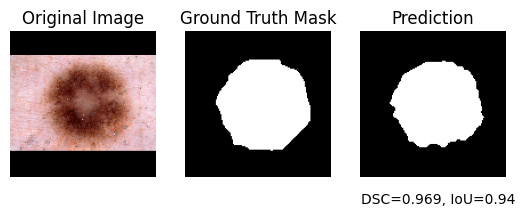

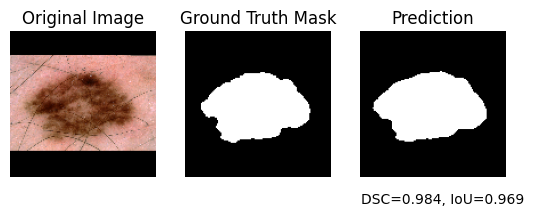

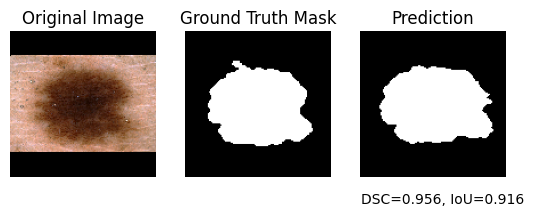

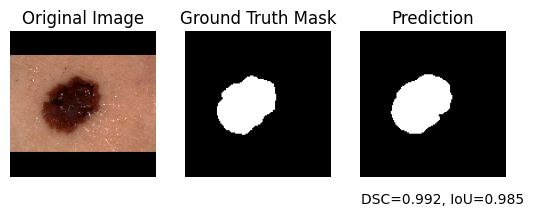

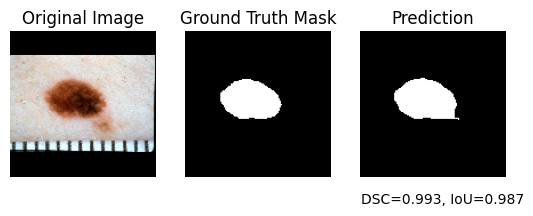

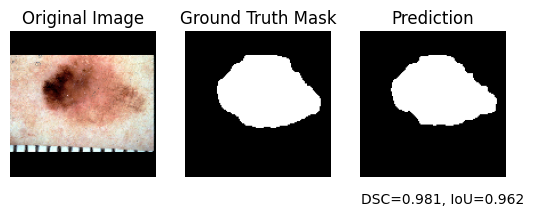

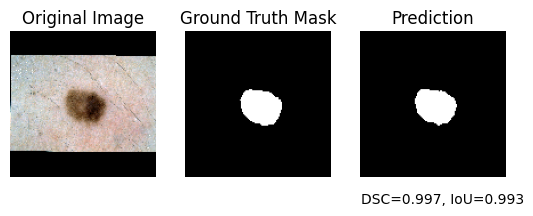

In [26]:
make_prediction(model, test_x, test_y, slice=(151, 161))

In [33]:
# Model evaluation

#Evaluate model performance
test_loss, test_dce, test_iou = model.evaluate(test_x,  test_y, verbose=2, batch_size=64)

4/4 - 0s - loss: 0.2532 - dice_similarity: 0.9528 - IoU: 0.9104 - 496ms/epoch - 124ms/step
